In [8]:
import os
import json
import time
import torch
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc
from monai.losses import ContrastiveLoss
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    ScaleIntensityd,
    LambdaD
)
import numpy as np

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [18]:
logdir_path = os.path.normpath("./logs/")

#Convert the train and validation images into a list with locations
train_dir = "./Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/"
val_dir = "./Data/FrenchSpeakerDataset/NRRD_Files_N4Bias_Val/"

#train image file
timage_filenames = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(".nrrd")])

#validation image files
vimage_filenames = sorted([os.path.join(val_dir, f)
                          for f in os.listdir(val_dir) if f.endswith(".nrrd")])

# Create a list of dictionaries containing the file paths
train_datalist = [{"image": img} for img in timage_filenames]
validation_datalist = [{"image": img} for img in vimage_filenames]

# Print the datalist to verify
print(train_datalist[0], validation_datalist[0])

{'image': './Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/P10_2.nrrd'} {'image': './Data/FrenchSpeakerDataset/NRRD_Files_N4Bias_Val/P1_2.nrrd'}


In [26]:
# Define Training Transforms
def threshold_image(image):
    return np.where(image < 20, 0, image)

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        # Defines the image intensity
        ScaleIntensityd(keys=["image"], minv=0, maxv=255),
        # Defines threshold for the image
        LambdaD(keys="image", func=threshold_image),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(64, 64, 64)),
        RandSpatialCropSamplesd(keys=["image"], roi_size=(
            64, 64, 64), random_size=False, num_samples=2),
        CopyItemsd(keys=["image"], times=2, names=[
            "gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8,
                           holes=10, spatial_size=8),
    ]
)


check_ds = Dataset(data=train_datalist, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image = check_data["image"][0][0]
print(f"image shape: {image.shape}")


image shape: torch.Size([64, 64, 64])


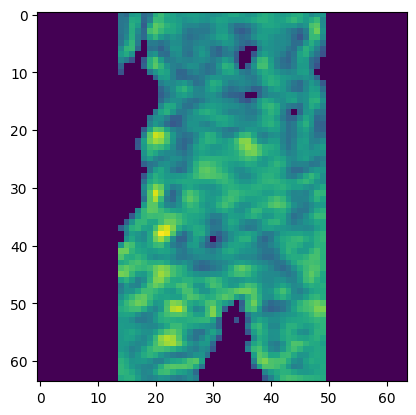

In [27]:
import matplotlib.pyplot as plt
plt.imshow(image[:,35,:])

In [28]:
# Training Config

# Define Network ViT backbone & Loss & Optimizer
device = torch.device("cpu")
model = ViTAutoEnc(
    in_channels=1,
    img_size=(64, 64, 64),
    patch_size=(16, 16, 16),
    proj_type="conv",
    hidden_size=768,
    mlp_dim=3072,
)

model = model.to(device)

# Define Hyper-paramters for training loop
experiment_name = "Train-Thresh-255-2000EP-16th"
max_epochs = 2000
val_interval = 2
batch_size = 4
lr = 1e-4
epoch_loss_values = []
step_loss_values = []
epoch_cl_loss_values = []
epoch_recon_loss_values = []
val_loss_values = []
best_val_loss = 1000.0

recon_loss = L1Loss()
contrastive_loss = ContrastiveLoss(temperature=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Define DataLoader using MONAI, CacheDataset needs to be used
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = Dataset(data=validation_datalist, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size,
                        shuffle=True, num_workers=1)


In [29]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_cl_loss = 0
    epoch_recon_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        start_time = time.time()

        inputs, inputs_2, gt_input = (
            batch_data["image"].to(device),
            batch_data["image_2"].to(device),
            batch_data["gt_image"].to(device),
        )
        optimizer.zero_grad()
        outputs_v1, hidden_v1 = model(inputs)
        outputs_v2, hidden_v2 = model(inputs_2)

        flat_out_v1 = outputs_v1.flatten(start_dim=1, end_dim=4)
        flat_out_v2 = outputs_v2.flatten(start_dim=1, end_dim=4)

        r_loss = recon_loss(outputs_v1, gt_input)
        cl_loss = contrastive_loss(flat_out_v1, flat_out_v2)

        # Adjust the CL loss by Recon Loss
        total_loss = r_loss + cl_loss * r_loss

        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        step_loss_values.append(total_loss.item())

        # CL & Recon Loss Storage of Value
        epoch_cl_loss += cl_loss.item()
        epoch_recon_loss += r_loss.item()

        end_time = time.time()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {total_loss.item():.4f}, "
            f"time taken: {end_time-start_time}s"
        )

    epoch_loss /= step
    epoch_cl_loss /= step
    epoch_recon_loss /= step

    epoch_loss_values.append(epoch_loss)
    epoch_cl_loss_values.append(epoch_cl_loss)
    epoch_recon_loss_values.append(epoch_recon_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if epoch % val_interval == 0:
        print("Entering Validation for epoch: {}".format(epoch + 1))
        total_val_loss = 0
        val_step = 0
        model.eval()
        for val_batch in val_loader:
            val_step += 1
            start_time = time.time()
            inputs, gt_input = (
                val_batch["image"].to(device),
                val_batch["gt_image"].to(device),
            )
            print("Input shape: {}".format(inputs.shape))
            outputs, outputs_v2 = model(inputs)
            val_loss = recon_loss(outputs, gt_input)
            total_val_loss += val_loss.item()
            end_time = time.time()

        total_val_loss /= val_step
        val_loss_values.append(total_val_loss)
        print(
            f"epoch {epoch + 1} Validation avg loss: {total_val_loss:.4f}, " f"time taken: {end_time-start_time}s")

        if total_val_loss < best_val_loss:
            print(
                f"Saving new model based on validation loss {total_val_loss:.4f}")
            best_val_loss = total_val_loss
            checkpoint = {"epoch": max_epochs, "state_dict": model.state_dict(
            ), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, os.path.join(logdir_path, experiment_name + ".pth"))

        plt.figure(1, figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epoch_loss_values)
        plt.grid()
        plt.title("Training Loss")

        plt.subplot(2, 2, 2)
        plt.plot(val_loss_values)
        plt.grid()
        plt.title("Validation Loss")

        plt.subplot(2, 2, 3)
        plt.plot(epoch_cl_loss_values)
        plt.grid()
        plt.title("Training Contrastive Loss")

        plt.subplot(2, 2, 4)
        plt.plot(epoch_recon_loss_values)
        plt.grid()
        plt.title("Training Recon Loss")

        plt.savefig(os.path.join(logdir_path, experiment_name + ".png"))
        plt.close(1)

print("Done")


----------
epoch 1/2000
1/174, train_loss: 39.7546, time taken: 3.3656439781188965s
2/174, train_loss: 42.2265, time taken: 4.150252819061279s
3/174, train_loss: 32.7458, time taken: 6.611802577972412s
4/174, train_loss: 34.2424, time taken: 5.789911985397339s
5/174, train_loss: 20.6644, time taken: 2.2932488918304443s
6/174, train_loss: 36.7667, time taken: 6.083348274230957s
7/174, train_loss: 19.6341, time taken: 4.015890836715698s
8/174, train_loss: 39.4123, time taken: 2.7896056175231934s
9/174, train_loss: 22.0674, time taken: 3.4997918605804443s
10/174, train_loss: 23.4378, time taken: 4.789405584335327s
11/174, train_loss: 21.1531, time taken: 2.192441701889038s
12/174, train_loss: 35.7936, time taken: 2.126340389251709s
13/174, train_loss: 31.2293, time taken: 2.027764320373535s
14/174, train_loss: 20.8219, time taken: 1.8021090030670166s
15/174, train_loss: 17.8462, time taken: 1.8696725368499756s
16/174, train_loss: 20.8244, time taken: 2.0844905376434326s
17/174, train_loss